# **Cloning Repo and Copying files**

In [1]:
! git clone https://github.com/csaw-hackml/CSAW-HackML-2020

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 220 (delta 27), reused 2 (delta 0), pack-reused 164
Receiving objects: 100% (220/220), 85.94 MiB | 21.51 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import keras
import sys
import h5py
import numpy as np 
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import pandas as pd

In [4]:
warnings.filterwarnings("ignore")

# **Backdoored Neural Network (BadNet)**

In [5]:
def data_preprocess(x_data):
    return x_data/255

In [6]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

In [7]:
clean_data_filename = '/content/gdrive/MyDrive/ML in Cyber Security/data/Lab3/cl/valid.h5'
model_filename = '/content/CSAW-HackML-2020/lab3/models/bd_net.h5'
poisoned_data_filename = '/content/gdrive/MyDrive/ML in Cyber Security/data/Lab3/bd/bd_valid.h5'

In [8]:
def main():
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    #cl_x_test = data_preprocess(cl_x_test)
    
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)
    #bd_x_test = data_preprocess(bd_x_test)

    bd_model = keras.models.load_model(model_filename)

    cl_label_pred = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_pred, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_pred = np.argmax(bd_model.predict(bd_x_test), axis=1)
    atk_success_rate = np.mean(np.equal(bd_label_pred, bd_y_test))*100
    print('Attack Success Rate:', atk_success_rate)

In [9]:
if __name__ == '__main__':
  main()

Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


In [10]:
clean_data_acc = 98.64899974019225
atk_success_rate = 100

In [11]:
bd_model = keras.models.load_model(model_filename)

In [12]:
print(bd_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

As we can see from the above summary, the backdoored neural network classifier has 1283 classes.

We also observe that the Last Pooling Layer has 60 channels.

# **Visualizing Cleaned and Posioned Images**

In [13]:
x_data, y_data = data_loader(clean_data_filename)

In [14]:
print(x_data.shape)
print(y_data.shape)

(11547, 55, 47, 3)
(11547,)


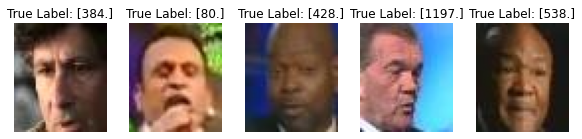

In [15]:
figure = plt.figure(figsize=(10,2))
cols, rows = 5,1
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("True Label: {}".format(label))
  plt.axis("off")
  plt.imshow(data_preprocess(img[0]))
plt.show()

In [16]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data_filename)

In [17]:
print(x_poisoned_data.shape)
print(y_poisoned_data.shape)

(11547, 55, 47, 3)
(11547,)


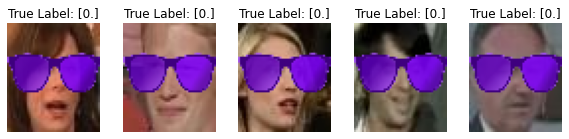

In [18]:
figure = plt.figure(figsize=(10,2))
cols, rows = 5,1
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("True Label: {}".format(label))
  plt.axis("off")
  plt.imshow(data_preprocess(img[0]))
plt.show()

In [19]:
keras.backend.clear_session()

# **Model Pruning**

In [20]:
pruned_model = keras.models.clone_model(bd_model)
pruned_model.set_weights(bd_model.get_weights()) 

In [21]:
weight_0 = pruned_model.layers[5].get_weights()[0]
bias_0 = pruned_model.layers[5].get_weights()[1]

In [22]:
pool_layer=pruned_model.get_layer('pool_3').output

In [23]:
pool_layer.shape

TensorShape([None, 5, 4, 60])

Getting the Average Activation Values

In [24]:
model=keras.models.Model(inputs=pruned_model.input,outputs=pruned_model.get_layer('pool_3').output)

prediction=model.predict(x_data) 

In [25]:
prediction.shape

(11547, 5, 4, 60)

In [26]:
avg_act_vals = np.mean(prediction,axis=(0,1,2))
print(avg_act_vals.shape)

(60,)


Channels sorted in descending order of Average Activation Values over the entire validation set and then Pruned.

In [27]:
avg_act_vals

array([0.0000000e+00, 8.5787797e-01, 0.0000000e+00, 5.3079778e-01,
       5.1451392e+00, 2.0289588e+00, 6.2408661e-03, 5.3690357e+00,
       2.1106052e+00, 0.0000000e+00, 4.1488924e+00, 2.1980376e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.5654888e+00, 0.0000000e+00, 5.0868411e+00, 2.4381575e-01,
       1.8378231e-01, 8.3539173e-02, 4.3979675e-02, 3.0290761e-03,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       4.8440871e+00, 1.0589781e+00, 0.0000000e+00, 0.0000000e+00,
       1.5006668e-02, 0.0000000e+00, 0.0000000e+00, 4.8648086e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 5.7658589e-01, 4.2763174e-01,
       0.0000000e+00, 0.0000000e+00, 1.8540378e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.3321567e-02,
       6.2038713e+00, 0.0000000e+00, 3.6191154e+00, 0.0000000e+00,
       1.6352932e+00, 8.2229824e+00, 5.0732863e-01, 0.0000000e

In [28]:
np.argsort(avg_act_vals)

array([ 0, 26, 27, 30, 31, 33, 34, 36, 37, 38, 25, 39, 41, 44, 45, 47, 48,
       49, 50, 53, 55, 40, 24, 59,  9,  2, 12, 13, 17, 14, 15, 23,  6, 51,
       32, 22, 21, 20, 19, 43, 58,  3, 42,  1, 29, 16, 56, 46,  5,  8, 11,
       54, 10, 28, 35, 18,  4,  7, 52, 57])

In [29]:
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)

In [30]:
seq = np.argsort(avg_act_vals)

for channel_index in tqdm(seq): 
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  pruned_model.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(pruned_model.predict(x_data), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, y_data))*100
  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("Accuracy drops at least  2%, model has been saved.")
    pruned_model.save('pruned_model_2p.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("Accuracy drops at least  4%, model has been saved.")
    pruned_model.save('pruned_model_4p.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("Accuracy drops at least 10%, model has been saved.")
    pruned_model.save('pruned_model_10p.h5')
    saved_model[2] = 1
  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(pruned_model.predict(x_poisoned_data), axis=1)
  asr = np.mean(np.equal(bd_label_p, y_poisoned_data))*100
  asrate.append(asr)
  print()
  print("Clean Accuracy: ",clean_accuracy,"%")
  print("Attack Success Rate: ",asr,"%")
  print("Pruned Channel Index: ",channel_index)
  keras.backend.clear_session()

  2%|▏         | 1/60 [00:21<20:47, 21.14s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  0


  3%|▎         | 2/60 [00:42<20:25, 21.14s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  26


  5%|▌         | 3/60 [00:59<18:26, 19.42s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  27


  7%|▋         | 4/60 [01:16<17:18, 18.54s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  30


  8%|▊         | 5/60 [01:35<17:08, 18.71s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  31


 10%|█         | 6/60 [01:52<16:20, 18.15s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  33


 12%|█▏        | 7/60 [02:12<16:20, 18.51s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  34


 13%|█▎        | 8/60 [02:33<16:44, 19.31s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  36


 15%|█▌        | 9/60 [02:52<16:21, 19.24s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  37


 17%|█▋        | 10/60 [03:13<16:36, 19.94s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  38


 18%|█▊        | 11/60 [03:32<16:04, 19.68s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  25


 20%|██        | 12/60 [03:53<16:04, 20.09s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  39


 22%|██▏       | 13/60 [04:13<15:37, 19.94s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  41


 23%|██▎       | 14/60 [04:30<14:38, 19.10s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  44


 25%|██▌       | 15/60 [04:49<14:19, 19.09s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  45


 27%|██▋       | 16/60 [05:11<14:29, 19.77s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  47


 28%|██▊       | 17/60 [05:28<13:36, 19.00s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  48


 30%|███       | 18/60 [05:45<12:53, 18.41s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  49


 32%|███▏      | 19/60 [06:02<12:22, 18.11s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  50


 33%|███▎      | 20/60 [06:21<12:15, 18.38s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  53


 35%|███▌      | 21/60 [06:42<12:27, 19.18s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  55


 37%|███▋      | 22/60 [07:02<12:10, 19.23s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  40


 38%|███▊      | 23/60 [07:33<14:05, 22.84s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  24


 40%|████      | 24/60 [07:54<13:23, 22.31s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  59


 42%|████▏     | 25/60 [08:15<12:52, 22.07s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  9


 43%|████▎     | 26/60 [08:36<12:19, 21.75s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  2


 45%|████▌     | 27/60 [08:54<11:12, 20.38s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  12


 47%|████▋     | 28/60 [09:15<11:02, 20.70s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  13


 48%|████▊     | 29/60 [09:34<10:27, 20.24s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  17


 50%|█████     | 30/60 [09:54<09:59, 20.00s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  14


 52%|█████▏    | 31/60 [10:11<09:17, 19.23s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  15


 53%|█████▎    | 32/60 [10:41<10:24, 22.29s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  23


 55%|█████▌    | 33/60 [11:00<09:37, 21.37s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  6


 57%|█████▋    | 34/60 [11:22<09:20, 21.57s/it]


Clean Accuracy:  98.64033948211657 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  51


 58%|█████▊    | 35/60 [11:46<09:18, 22.34s/it]


Clean Accuracy:  98.64033948211657 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  32


 60%|██████    | 36/60 [12:05<08:34, 21.44s/it]


Clean Accuracy:  98.63167922404088 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  22


 62%|██████▏   | 37/60 [12:26<08:05, 21.12s/it]


Clean Accuracy:  98.65765999826795 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  21


 63%|██████▎   | 38/60 [12:46<07:38, 20.82s/it]


Clean Accuracy:  98.64899974019225 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  20


 65%|██████▌   | 39/60 [13:07<07:18, 20.89s/it]


Clean Accuracy:  98.6056984498138 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  19


 67%|██████▋   | 40/60 [13:29<07:03, 21.16s/it]


Clean Accuracy:  98.57105741751104 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  43


 68%|██████▊   | 41/60 [13:48<06:33, 20.70s/it]


Clean Accuracy:  98.53641638520828 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  58


 70%|███████   | 42/60 [14:09<06:13, 20.77s/it]


Clean Accuracy:  98.19000606218066 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  3


 72%|███████▏  | 43/60 [14:31<05:56, 20.94s/it]


Clean Accuracy:  97.65307006148784 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  42


 73%|███████▎  | 44/60 [14:52<05:35, 20.97s/it]


Clean Accuracy:  97.50584567420108 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  1
Accuracy drops at least  2%, model has been saved.


 75%|███████▌  | 45/60 [15:23<06:03, 24.20s/it]


Clean Accuracy:  95.75647354291158 %
Attack Success Rate:  100.0 %
Pruned Channel Index:  29


 77%|███████▋  | 46/60 [15:45<05:29, 23.56s/it]


Clean Accuracy:  95.20221702606739 %
Attack Success Rate:  99.9913397419243 %
Pruned Channel Index:  16


 78%|███████▊  | 47/60 [16:05<04:51, 22.45s/it]


Clean Accuracy:  94.7172425738287 %
Attack Success Rate:  99.9913397419243 %
Pruned Channel Index:  56
Accuracy drops at least  4%, model has been saved.


 80%|████████  | 48/60 [16:25<04:19, 21.59s/it]


Clean Accuracy:  92.09318437689443 %
Attack Success Rate:  99.9913397419243 %
Pruned Channel Index:  46


 82%|████████▏ | 49/60 [16:47<03:58, 21.71s/it]


Clean Accuracy:  91.49562656967177 %
Attack Success Rate:  99.9913397419243 %
Pruned Channel Index:  5


 83%|████████▎ | 50/60 [17:06<03:28, 20.87s/it]


Clean Accuracy:  91.01931237550879 %
Attack Success Rate:  99.98267948384861 %
Pruned Channel Index:  8


 85%|████████▌ | 51/60 [17:27<03:08, 20.93s/it]


Clean Accuracy:  89.17467740538669 %
Attack Success Rate:  80.73958603966398 %
Pruned Channel Index:  11
Accuracy drops at least 10%, model has been saved.


 87%|████████▋ | 52/60 [17:48<02:47, 20.99s/it]


Clean Accuracy:  84.43751623798389 %
Attack Success Rate:  77.015675067117 %
Pruned Channel Index:  54


 88%|████████▊ | 53/60 [18:09<02:27, 21.02s/it]


Clean Accuracy:  76.48739932449988 %
Attack Success Rate:  35.71490430414826 %
Pruned Channel Index:  10


 90%|█████████ | 54/60 [18:29<02:03, 20.62s/it]


Clean Accuracy:  54.8627349095003 %
Attack Success Rate:  6.954187234779596 %
Pruned Channel Index:  28


 92%|█████████▏| 55/60 [18:48<01:40, 20.14s/it]


Clean Accuracy:  27.08928726076037 %
Attack Success Rate:  0.4243526457088421 %
Pruned Channel Index:  35


 93%|█████████▎| 56/60 [19:09<01:21, 20.44s/it]


Clean Accuracy:  13.87373343725643 %
Attack Success Rate:  0.0 %
Pruned Channel Index:  18


 95%|█████████▌| 57/60 [19:51<01:20, 26.87s/it]


Clean Accuracy:  7.101411622066338 %
Attack Success Rate:  0.0 %
Pruned Channel Index:  4


 97%|█████████▋| 58/60 [20:08<00:48, 24.02s/it]


Clean Accuracy:  1.5501861955486274 %
Attack Success Rate:  0.0 %
Pruned Channel Index:  7


 98%|█████████▊| 59/60 [20:29<00:23, 23.14s/it]


Clean Accuracy:  0.7188014202823244 %
Attack Success Rate:  0.0 %
Pruned Channel Index:  52


100%|██████████| 60/60 [20:47<00:00, 20.78s/it]


Clean Accuracy:  0.0779423226812159 %
Attack Success Rate:  0.0 %
Pruned Channel Index:  57


In [31]:
print("Clean Accuracy List: ",clean_acc)

Clean Accuracy List:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.4375162

# **Accuracy and Attack Success Rate for Pruned Model**

Text(0, 0.5, 'Rate')

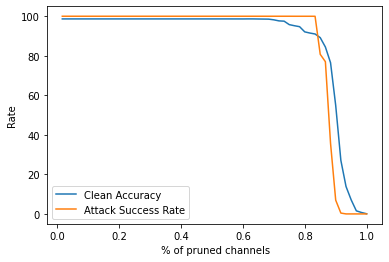

In [32]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asrate)
plt.legend(['Clean Accuracy','Attack Success Rate'])
plt.xlabel(" % of pruned channels")
plt.ylabel("Rate")

We observe from the visualization that, as we remove the 60% of Channels with lower average activation values, there is no change in the clean accuracy and attack success rate.

And after that there is a significant drop in both the clean accuracy and attack success rate which implies that backdoor functionality has been embedded in the same neurons that are activated by clean inputs and not on the unactivated neurons. Therefore, just pruning isn't effective in this case.

Possible Adaptive Attack in which case Pruning doesn't work as it also prunes useful neurons if attacker has backdoored using activated neurons.


# **Good Net**

This model has been created by using BadNet and Pruned Model. If the predictions in both models match then the ouput will be the prediction itself else the output class wil be 1284 (1283 + 1)

In [33]:
class Model(keras.Model):
  def __init__(self, bad_net, bad_net_pruned):
      super(Model, self).__init__()
      self.bad_net = bad_net
      self.bad_net_pruned = bad_net_pruned

  def predict(self,data):
      y = np.argmax(self.bad_net(data), axis=1)
      y_prime = np.argmax(self.bad_net_pruned(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1284
      return pred

In [34]:
test_data_filename = '/content/gdrive/MyDrive/ML in Cyber Security/data/Lab3/cl/test.h5'
poisoned_test_data_filename = '/content/gdrive/MyDrive/ML in Cyber Security/data/Lab3/bd/bd_test.h5'
pruned_model_2p_filename = '/content/pruned_model_2p.h5'
pruned_model_4p_filename = '/content/pruned_model_4p.h5'
pruned_model_10p_filename = '/content/pruned_model_10p.h5'

In [35]:
pruned_model_2p = keras.models.load_model(pruned_model_2p_filename)
pruned_model_4p = keras.models.load_model(pruned_model_4p_filename)
pruned_model_10p = keras.models.load_model(pruned_model_10p_filename)

In [36]:
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisoned_data = data_loader(poisoned_test_data_filename)

In [37]:
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [38]:
print("y_test_data shape: ",y_test_data.shape)
print("y_test_poisoned data shape: ",y_test_poisoned_data.shape)

y_test_data shape:  (12830,)
y_test_poisoned data shape:  (12830,)


In [39]:
G_model_2p = Model(bd_model, pruned_model_2p)
G_model_4p = Model(bd_model, pruned_model_4p)
G_model_10p = Model(bd_model, pruned_model_10p)

# **Results**

In [40]:
cl_label_pred_X_2 = np.argmax(pruned_model_2p.predict(x_test_data), axis=1)
clean_accuracy_X_2 = np.mean(np.equal(cl_label_pred_X_2, y_test_data))*100
    
bd_label_pred_X_2 = np.argmax(pruned_model_2p.predict(x_test_poisoned_data), axis=1)
atk_success_rate_X_2 = np.mean(np.equal(bd_label_pred_X_2, y_test_poisoned_data))*100

print('Model with a 2% Repair:')
print('Clean Classification accuracy:', clean_accuracy_X_2,"%")
print('Attack Success Rate:', atk_success_rate_X_2,"%")

Model with a 2% Repair:
Clean Classification accuracy: 95.90023382696803 %
Attack Success Rate: 100.0 %


In [41]:
cl_label_pred_X_4 = np.argmax(pruned_model_4p.predict(x_test_data), axis=1)
clean_accuracy_X_4 = np.mean(np.equal(cl_label_pred_X_4, y_test_data))*100
    
bd_label_pred_X_4 = np.argmax(pruned_model_4p.predict(x_test_poisoned_data), axis=1)
atk_success_rate_X_4 = np.mean(np.equal(bd_label_pred_X_4, y_test_poisoned_data))*100

print('Model with a 4% Repair:')
print('Clean Classification accuracy:', clean_accuracy_X_4,"%")
print('Attack Success Rate:', atk_success_rate_X_4,"%")

Model with a 4% Repair:
Clean Classification accuracy: 92.29150428682775 %
Attack Success Rate: 99.98441153546376 %


In [42]:
cl_label_pred_X_10 = np.argmax(pruned_model_10p.predict(x_test_data), axis=1)
clean_accuracy_X_10 = np.mean(np.equal(cl_label_pred_X_10, y_test_data))*100
    
bd_label_pred_X_10 = np.argmax(pruned_model_10p.predict(x_test_poisoned_data), axis=1)
atk_success_rate_X_10 = np.mean(np.equal(bd_label_pred_X_10, y_test_poisoned_data))*100

print('Model with a 10% Repair:')
print('Clean Classification accuracy:', clean_accuracy_X_10,"%")
print('Attack Success Rate:', atk_success_rate_X_10,"%")

Model with a 10% Repair:
Clean Classification accuracy: 84.54403741231489 %
Attack Success Rate: 77.20966484801247 %


In [43]:
G_cl_label_pred_X_2 = G_model_2p.predict(x_test_data)
G_clean_accuracy_X_2 = np.mean(np.equal(G_cl_label_pred_X_2, y_test_data))*100
    
G_bd_label_pred_X_2 = G_model_2p.predict(x_test_poisoned_data)
G_atk_success_rate_X_2 = np.mean(np.equal(G_bd_label_pred_X_2, y_test_poisoned_data))*100

print('Combined Model with a 2% Repair:')
print('Clean Classification accuracy:', G_clean_accuracy_X_2,"%")
print('Attack Success Rate:', G_atk_success_rate_X_2,"%")

Combined Model with a 2% Repair:
Clean Classification accuracy: 95.74434918160561 %
Attack Success Rate: 100.0 %


In [44]:
G_cl_label_pred_X_4 = G_model_4p.predict(x_test_data)
G_clean_accuracy_X_4 = np.mean(np.equal(G_cl_label_pred_X_4, y_test_data))*100
    
G_bd_label_pred_X_4 = G_model_4p.predict(x_test_poisoned_data)
G_atk_success_rate_X_4 = np.mean(np.equal(G_bd_label_pred_X_4, y_test_poisoned_data))*100

print('Combined Model with a 4% Repair:')
print('Clean Classification accuracy:', G_clean_accuracy_X_4,"%")
print('Attack Success Rate:', G_atk_success_rate_X_4,"%")

Combined Model with a 4% Repair:
Clean Classification accuracy: 92.1278254091972 %
Attack Success Rate: 99.98441153546376 %


In [46]:
G_cl_label_pred_X_10 = G_model_10p.predict(x_test_data)
G_clean_accuracy_X_10 = np.mean(np.equal(G_cl_label_pred_X_10, y_test_data))*100
    
G_bd_label_pred_X_10 = G_model_10p.predict(x_test_poisoned_data)
G_atk_success_rate_X_10 = np.mean(np.equal(G_bd_label_pred_X_10, y_test_poisoned_data))*100

print('Combined Model with a 10% Repair:')
print('Clean Classification accuracy:', G_clean_accuracy_X_10,"%")
print('Attack Success Rate:', G_atk_success_rate_X_10,"%")

Combined Model with a 10% Repair:
Clean Classification accuracy: 84.3335931410756 %
Attack Success Rate: 77.20966484801247 %
